# Lesson 7: Probability Fundamentals

*Teachers:* Fares Schulz, Lina Campanella

In this course we will cover:
1. Probability distributions
2. Sampling from distributions
3. Bayes' Theorem
4. Maximum Likelihood

This script was inspired by the Creative Machine Learning course of Philippe Esling

In [52]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.distributions as distribution
import seaborn as sns
import torch
from torch.utils.data import random_split

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

## Coin toss

Let's start with the most intuitive random process: a coin flip. In the example below, we simulate multiple coin tosses using Python's random number generator.

In [4]:
sample_space = ['heads', 'tails']
trials = 5
for t in range(trials):
    # Get a random 0 or 1
    toss = random.randint(0,1)
    # Print the result of our toss
    print('Coin is tossed on ' + sample_space[toss])

Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on tails


Each time we run this code, we get a different outcome due to randomness. But what happens when we repeat the experiment many times? By sampling thousands of coin flips, patterns emerge. We can observe the **distribution** that underlies the random process. 

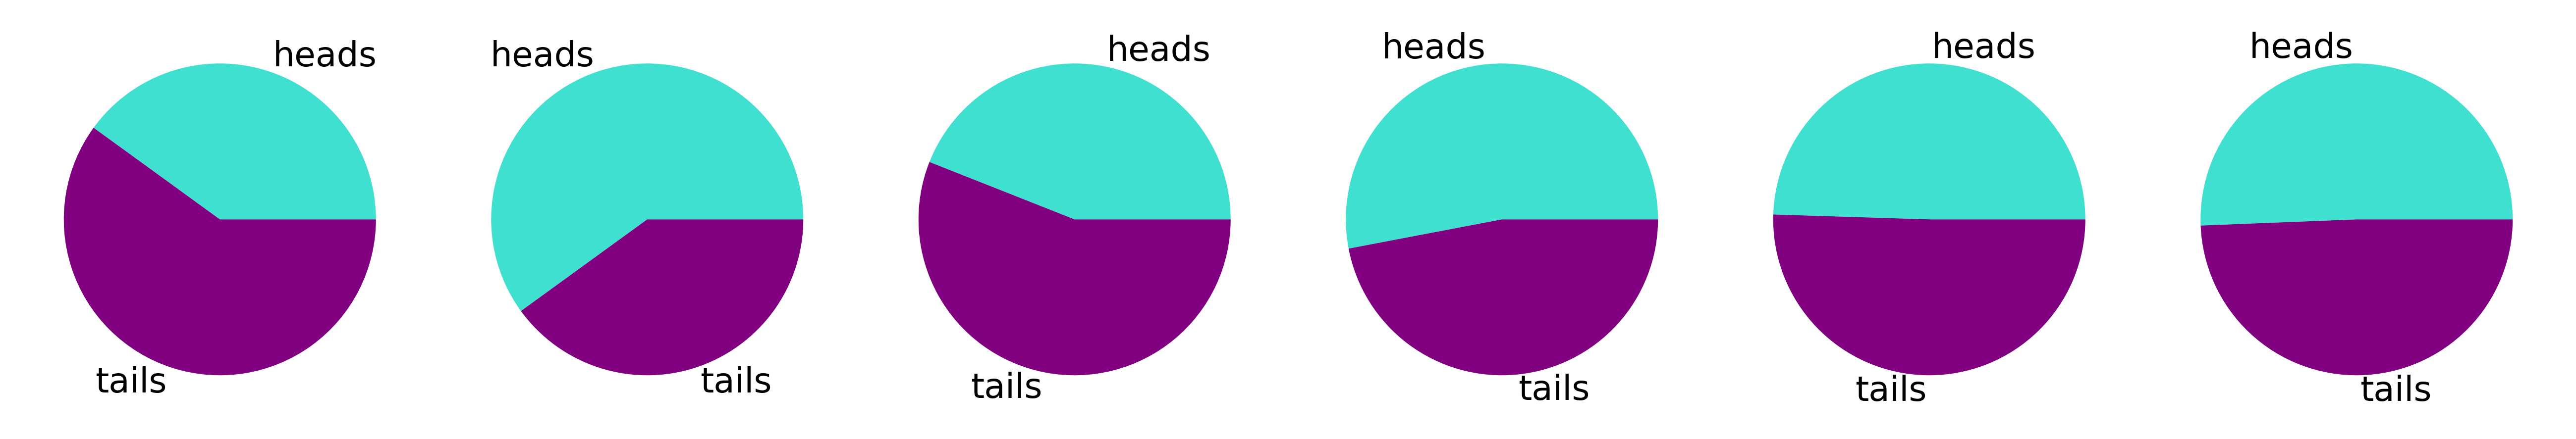

In [21]:
fig = plt.figure(figsize=(10.5, 2.5), dpi=500, tight_layout=True)
# loop through 5,10,50,100,1000,10000 trials
for t_id, trials in enumerate([5,10,50,100,1000,10000]):
    # Keep track
    heads_or_tails = [0, 0]
    for t in range(trials):
        # Get a random 0 or 1
        toss = random.randint(0,1)
        # Increment the list element corresponding to the toss result
        heads_or_tails[toss] = heads_or_tails[toss] + 1
    # Show a pie chart of the results
    plt.subplot(1, 6, t_id+1)
    plt.pie(heads_or_tails, colors=['turquoise', 'purple'], labels=['heads', 'tails'])
    
plt.show()

## Distributions

### Bernoulli distribution

A very simple example of discrete distribution is the **Bernoulli** distribution. With this distribution, we can model a coin flip, if it has equal probability. More formally, a Bernoulli distribution is defined as

$$ 
Bernoulli(x)= p^x (1-p)^{(1-x)} 
$$

with $p$ controlling the probability of the two classes. That means that fair coin should have $p=0.5$. If we throw the coin a very large number of times, we hope to see on average an equal amount of _heads_ and _tails_.

tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 0.])


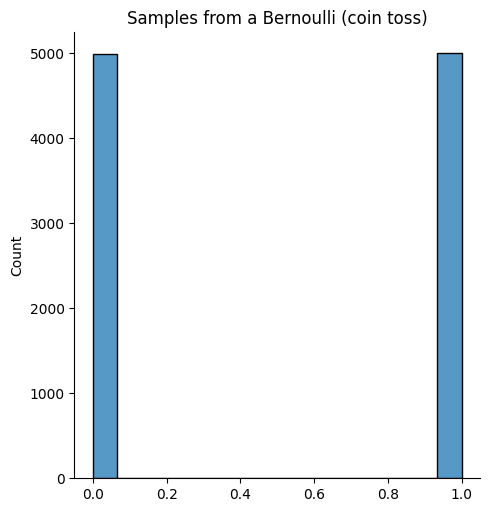

In [34]:
bernoulli = distribution.Bernoulli(0.5)
# bernoulli = distribution.Bernoulli(0.2)
samples = bernoulli.sample((10000,))
print(samples[:10])
# figure(640, 480)
sns.displot(samples)
plt.title("Samples from a Bernoulli (coin toss)")
plt.show()

In [35]:
sample_space = ['heads', 'tails']
samples = bernoulli.sample((10, ))
for s in samples:
    print('Coin is tossed on ' + sample_space[int(s)])

Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on tails
Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on tails


### Normal distribution

The same ideas apply to *continuous* random variables. The Normal (or Gaussian) distribution is perhaps the most important distribution in statistics and machine learning. Below, two normal distibutions are plottet using `pytorch.distribution`.

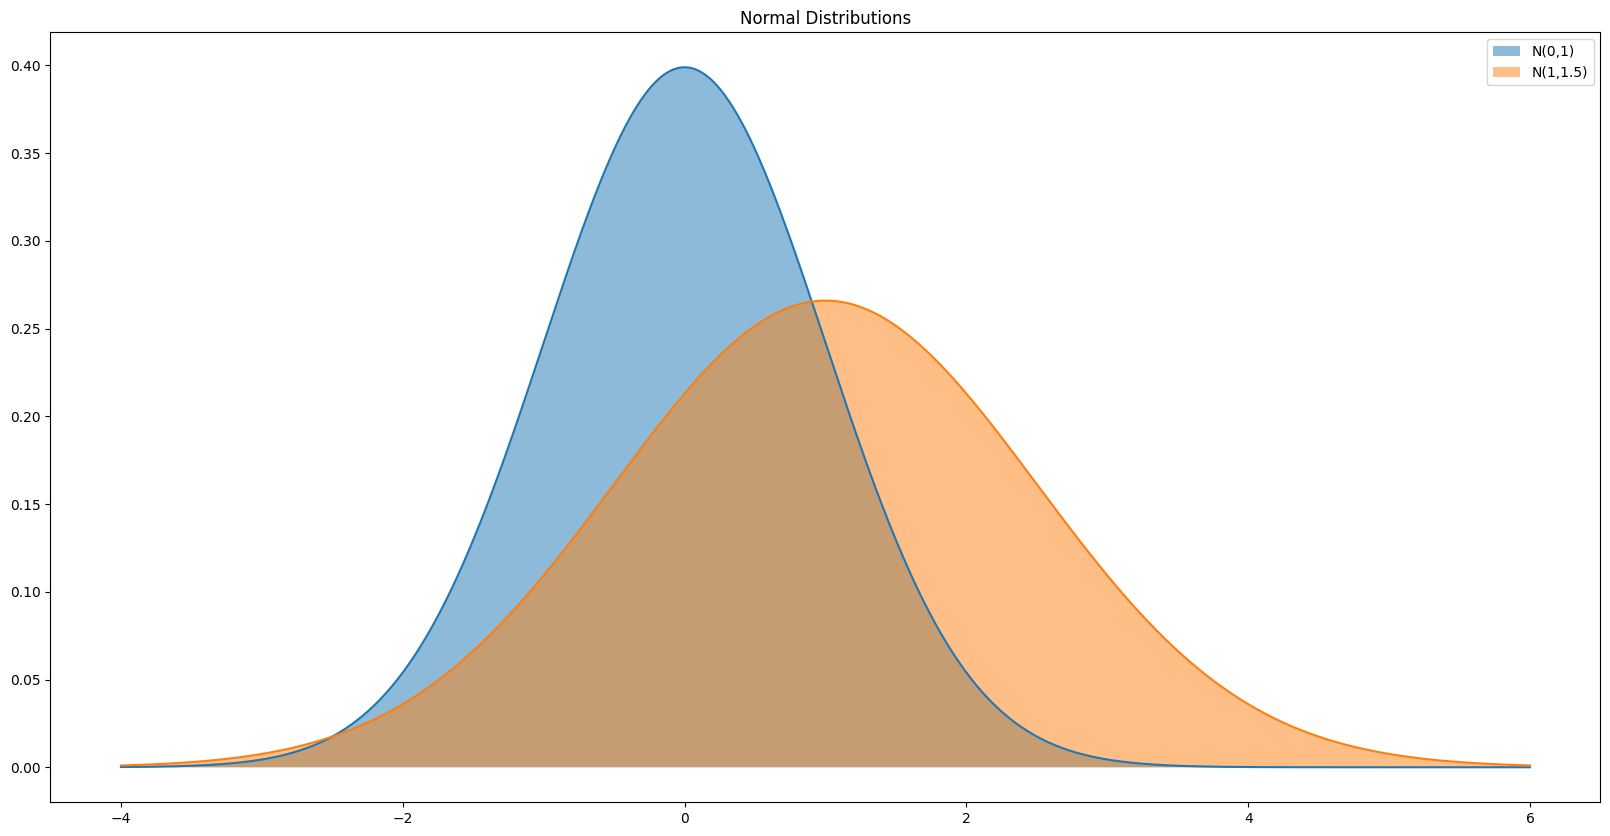

In [92]:
x = np.linspace(-4, 6, 1000)

# Based on a normal
n_1 = distribution.Normal(0, 1)
n_2 = distribution.Normal(1, 1.5)

# Obtain some samples
samples = n_1.sample((1000, ))

# Evaluate true density at given points
density_1 = torch.exp(n_1.log_prob(torch.Tensor(x))).numpy()
density_2 = torch.exp(n_2.log_prob(torch.Tensor(x))).numpy()

# Plot both samples and density
plt.figure(figsize=(20, 10))

# Compare both distributions
plt.plot(x, density_1)
plt.fill_between(x, density_1, 0, alpha=0.5, label='N(0,1)')
plt.plot(x, density_2)
plt.fill_between(x, density_2, 0, alpha=0.5, label='N(1,1.5)')
plt.legend()
plt.title("Normal Distributions")
plt.show()

Here, we rely on the [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`. Inside this toolbox, we can already find some of the major probability distributions that we are used to deal with:

- ``distribution.Normal``
- ``distribution.Bernoulli``
- ``distribution.Beta``
- ``distribution.Gamma``
- ``distribution.LogNormal``

## Sampling from a distribution

Once we know a probability distribution, we can sample from it. For example, sampling repeatedly from a Gaussian distribution produces values that perfectly match the Gaussian shape. The trick is this: to sample from any distribution, we need to invert the Cumulative Distribution Function (CDF). The CDF tells us the cumulative probability up to any point x; inverting it lets us map uniform random numbers directly to samples from our target distribution.

Below, we demonstrate this with the exponential distribution, comparing both the standard NumPy sampling method and the inverse CDF approach.

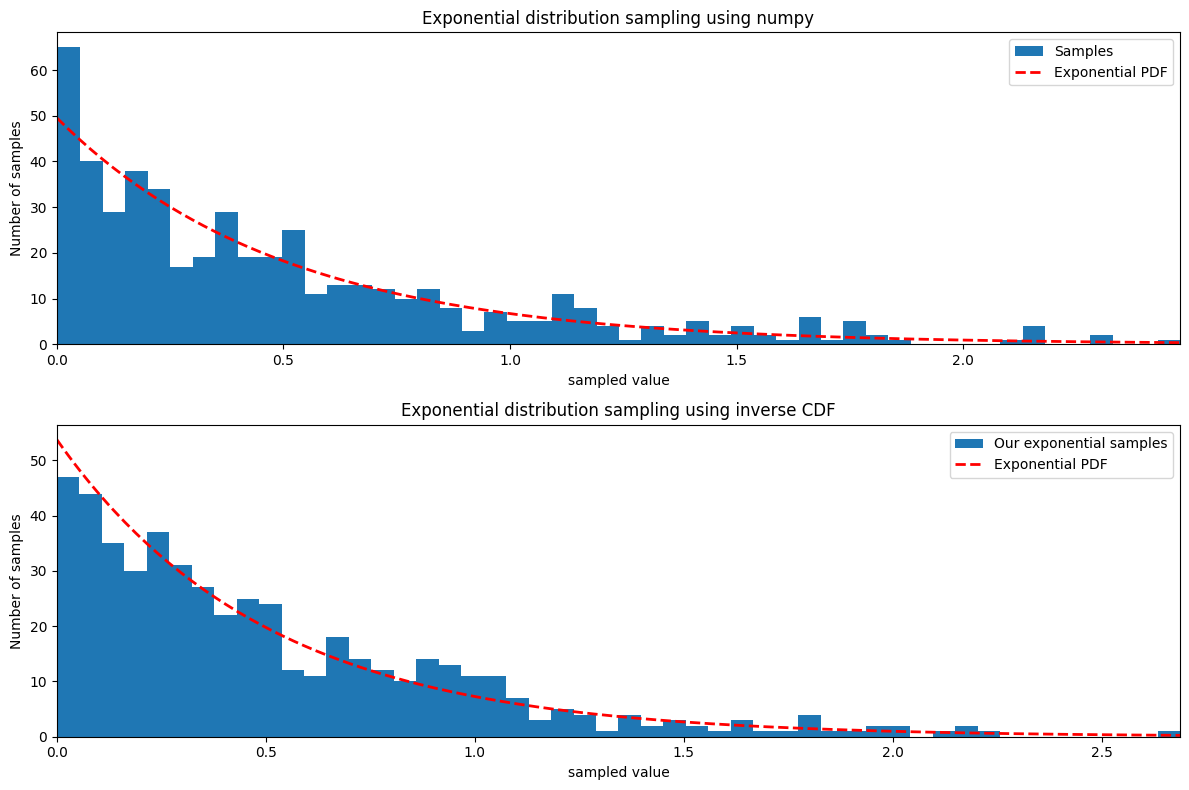

In [ ]:
from scipy.stats import expon
nb_samples = 500
nb_bins = 50

def sample_exponential(mu, n):
    samples = []
    u = np.random.uniform(0, 1, n)  # Generate uniform random number
    samples = -mu * np.log(u)       # Apply inverse CDF
    
    return samples

# Exponential distribution
B = 0.5
samples = np.random.exponential(B, nb_samples)
samples_manual = sample_exponential(B, nb_samples)

# Compute the PDF
X = np.linspace(0, np.max(samples), int(np.max(samples)) * 100)
X_manual = np.linspace(0, np.max(samples_manual), int(np.max(samples_manual)) * 100)
y = expon.pdf(X, scale=B)
y_manual = (1/B) * np.exp(-X_manual/B)

# Display both
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
counts, bin_edges, _ = plt.hist(samples, 50, label='Samples')
bin_width = bin_edges[1] - bin_edges[0]
plt.plot(X, y * bin_width * nb_samples,ls='--',c='r',linewidth=2, label='Exponential PDF')
plt.legend(loc=1)
plt.xlim(0, max(samples))
plt.xlabel('sampled value')
plt.ylabel('Number of samples')
plt.title('Exponential distribution sampling using numpy')

plt.subplot(2,1,2)
counts, bin_edges, _ = plt.hist(samples_manual, 50, label='Our exponential samples')
bin_width = bin_edges[1] - bin_edges[0]
plt.plot(X_manual, y_manual * bin_width * nb_samples,ls='--',c='r',linewidth=2, label='Exponential PDF')
plt.legend(loc=1)
plt.xlabel('sampled value')
plt.ylabel('Number of samples')
plt.xlim(0, max(samples_manual))
plt.title('Exponential distribution sampling using inverse CDF')
plt.tight_layout()
plt.show()

## Bayes' Theorem

...

### Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution. We have the following data.

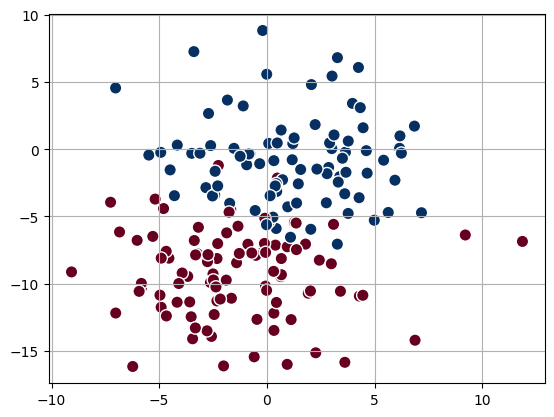

In [63]:
from sklearn.datasets import make_blobs
X, y = make_blobs(200, 2, centers=2, random_state=2, cluster_std=3.2)

train_idx = np.random.choice(len(X), int(0.9 * len(X)), replace=False)
test_idx = np.array([i for i in range(len(X)) if i not in train_idx])

X_train = X[train_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=80, cmap='RdBu', edgecolor='w'); plt.grid(True)

We need an algorithm that learns the mean and variance of each feature for each class, then uses Bayes' theorem to make predictions:

$$P(\text{class} | \text{data}) = \frac{P(\text{data} | \text{class}) \cdot P(\text{class})}{P(\text{data})}$$

We'll build it from scratch to understand what's happening under the hood. Afterwards we'll use the the scikit-learn implementation to compare our results.

In [72]:
# Naive Bayes Classifier Class

class NaiveBayesClassifier:

    def __init__(self):
        pass

    # Separate the dataset into a subset of data for each class
    def separate_classes(self, X, y):
        """
        Separates the dataset in to a subset of data for each class.
        Parameters:
        ------------
        X - array, list of features
        y - list, target
        Returns:
        A dictionary with y as keys and assigned X as values.
        """
        separated_classes = {}
        for i in range(len(X)):
            feature_values = X[i]
            class_name = y[i]
            if class_name not in separated_classes:
                separated_classes[class_name] = []
            separated_classes[class_name].append(feature_values)
        return separated_classes

    # Standard deviation and mean are required for the (Gaussian) distribution function

    def stat_info(self, X):
        """
        Calculates standard deviation and mean of features.
        Parameters:
        ------------
        X- array , list of features
        Returns:
        A dictionary with STD and Mean as keys and assigned features STD and Mean as values.
        """
        for feature in zip(*X):
            yield {
                'std' : np.std(feature),
                'mean' : np.mean(feature)
            }
            
    # Required fit method, to train the model

    def fit(self, X, y):
        """
        Trains the model.
        Parameters:
        ----------
        X: array-like, training features
        y: list, target variable
        Returns:
        Dictionary with the prior probability, mean, and standard deviation of each class
        """

        separated_classes = self.separate_classes(X, y)
        self.class_summary = {}

        for class_name, feature_values in separated_classes.items():
            self.class_summary[class_name] = {
                'prior_proba': len(feature_values)/len(X),
                'summary': [i for i in self.stat_info(feature_values)],
            }
        return self.class_summary

    # Gaussian distribution function

    def distribution(self, x, mean, std):
        """
        Gaussian Distribution Function
        Parameters:
        ----------
        x: float, value of feature
        mean: float, the average value of feature
        stdev: float, the standard deviation of feature
        Returns:
        A value of Normal Probability
        """

        exponent = np.exp(-(((x-mean)/std)**2)/2)

        return exponent/(np.sqrt(2*np.pi)*std)

    # Required predict method, to predict the class

    def predict(self, X):
        """
        Predicts the class.
        Parameters:
        ----------
        X: array-like, test data set
        Returns:
        -----------
        List of predicted class for each row of data set
        """

        # Maximum a posteriori (MAP)
        
        MAPs = []

        for row in X:
            joint_proba = {}
            
            for class_name, features in self.class_summary.items():
                total_features = len(features['summary'])
                likelihood = 1

                for idx in range(total_features):
                    feature = row[idx]
                    mean = features['summary'][idx]['mean']
                    stdev = features['summary'][idx]['std']
                    normal_proba = self.distribution(feature, mean, stdev)
                    likelihood *= normal_proba
                prior_proba = features['prior_proba']
                joint_proba[class_name] = prior_proba * likelihood

            MAP = max(joint_proba, key=joint_proba.get)
            MAPs.append(MAP)

        return np.array(MAPs)
    
    # equivalent function to scikit-learns predict_proba
    
    def predict_proba(self, X):
        """Returns probabilities for each class"""
        probas = []
        for row in X:
            joint_proba = {}
            for class_name, features in self.class_summary.items():
                likelihood = 1
                for idx in range(len(features['summary'])):
                    feature = row[idx]
                    mean = features['summary'][idx]['mean']
                    stdev = features['summary'][idx]['std']
                    likelihood *= self.distribution(feature, mean, stdev)
                joint_proba[class_name] = features['prior_proba'] * likelihood
            
            total = sum(joint_proba.values())
            prob_class_0 = joint_proba.get(0, 0) / total
            prob_class_1 = joint_proba.get(1, 0) / total
            probas.append([prob_class_0, prob_class_1])
    
        return np.array(probas)
    
    # Calculate the model's accuracy

    def accuracy(self, y_test, y_pred):
        """
        Calculates model's accuracy.
        Parameters:
        ------------
        y_test: actual values
        y_pred: predicted values
        Returns:
        ------------
        A number between 0-1, representing the percentage of correct predictions.
        """

        true_true = 0

        for y_t, y_p in zip(y_test, y_pred):
            if y_t == y_p:
                true_true += 1 
        return true_true / len(y_test)

Before we build the classifier, let's visualize the distribution of each class. We'll look at the distribution of feature 0 (x-axis) for both classes to see how they differ.

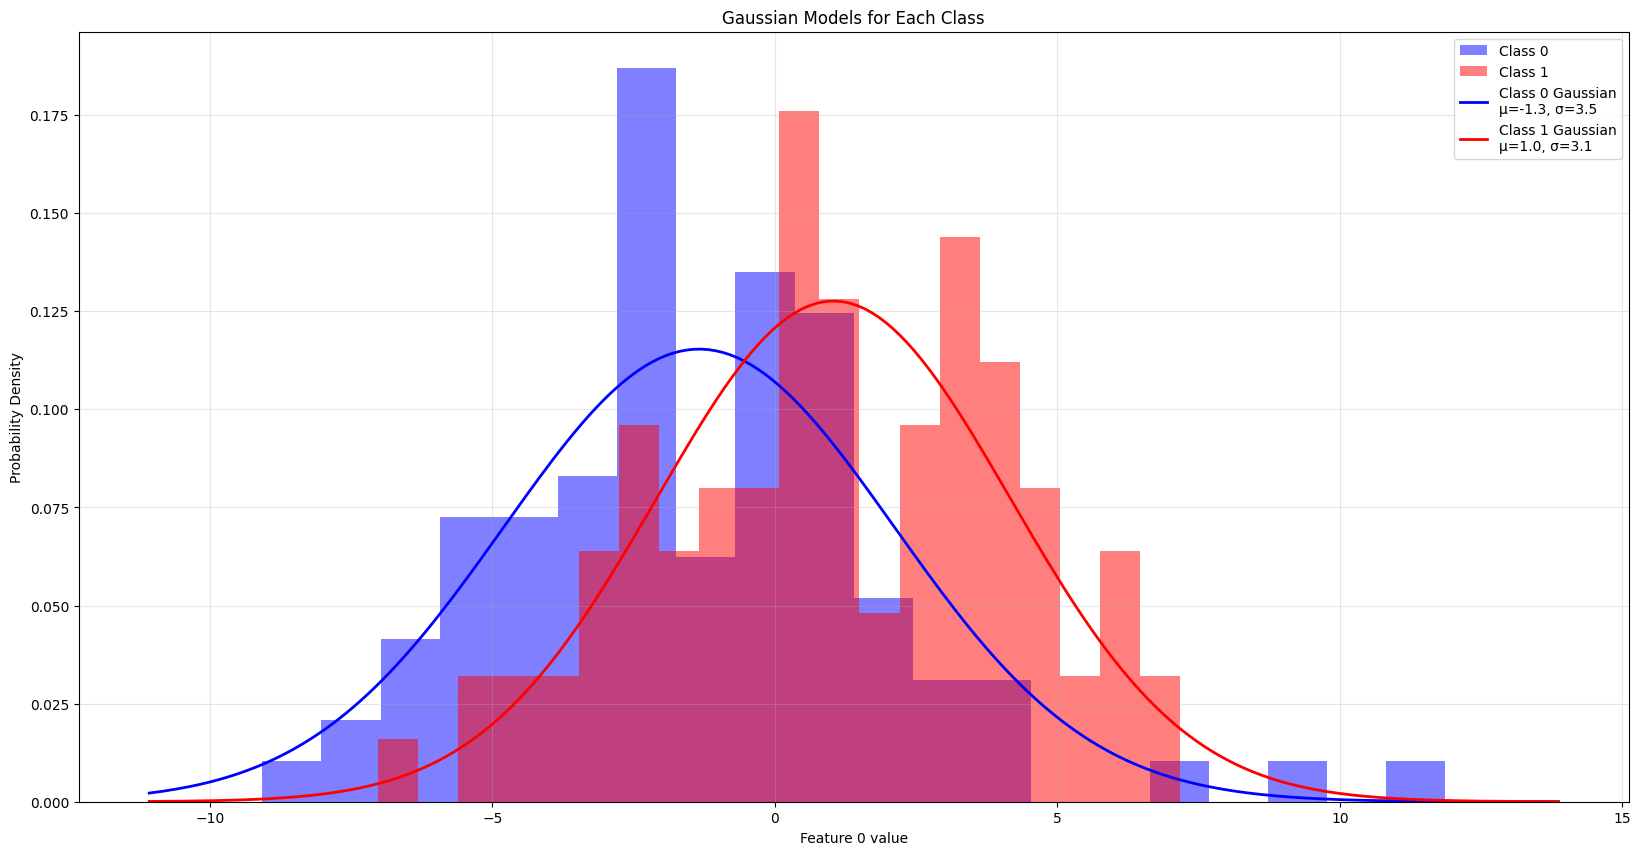

In [73]:
from scipy.stats import norm

model = NaiveBayesClassifier()
seperate_classes = model.separate_classes(X_train, y_train)

# Convert lists to NumPy arrays for indexing
class_0_data = np.asarray(seperate_classes[0])
class_1_data = np.asarray(seperate_classes[1])

# Create a 1D visualization using feature 0 (x-coordinate)
plt.figure(figsize=(20, 10))

# Plot 1: Histogram + fitted Gaussian for feature 0
feature_idx = 0
plt.hist(class_0_data[:, feature_idx], bins=20, alpha=0.5, color='blue', density=True, label='Class 0')
plt.hist(class_1_data[:, feature_idx], bins=20, alpha=0.5, color='red', density=True, label='Class 1')

# Fit Gaussians to each class
mean_0 = np.mean(class_0_data[:, feature_idx])
std_0 = np.std(class_0_data[:, feature_idx])
mean_1 = np.mean(class_1_data[:, feature_idx])
std_1 = np.std(class_1_data[:, feature_idx])

# Plot the Gaussian curves
x_min = min(class_0_data[:, feature_idx].min(), class_1_data[:, feature_idx].min()) - 2
x_max = max(class_0_data[:, feature_idx].max(), class_1_data[:, feature_idx].max()) + 2
x_range = np.linspace(x_min, x_max, 200)

gaussian_0 = norm.pdf(x_range, mean_0, std_0)
gaussian_1 = norm.pdf(x_range, mean_1, std_1)

plt.plot(x_range, gaussian_0, 'b-', linewidth=2, label=f'Class 0 Gaussian\nμ={mean_0:.1f}, σ={std_0:.1f}')
plt.plot(x_range, gaussian_1, 'r-', linewidth=2, label=f'Class 1 Gaussian\nμ={mean_1:.1f}, σ={std_1:.1f}')
plt.xlabel('Feature 0 value')
plt.ylabel('Probability Density')
plt.title('Gaussian Models for Each Class')
plt.legend()
plt.grid(True, alpha=0.3)

Next, we plot the data and see where the decision boundary is.

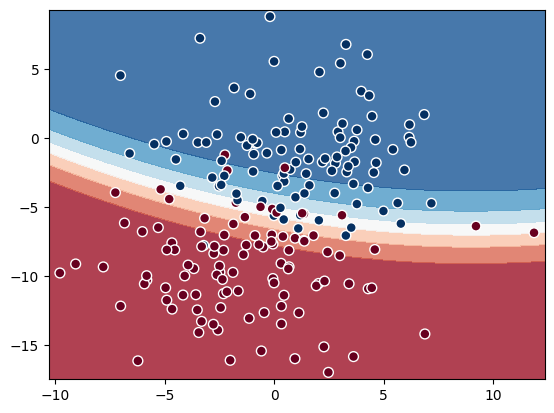

In [74]:
model.fit(X, y)

# predict the classification probabilities on a grid
xlim = X[:, 0].min() - .5, X[:, 0].max() + .5
ylim = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu', edgecolor='w')

The decision boundary is slightly curved rather than straight. This happens because Gaussian Naive Bayes compares two Gaussian probability distributions, and the math results in a quadratic equation—producing parabolas, ellipses, or hyperbolas as boundaries.



We can also try to predict the test values and calculate the accuracy.

In [77]:
y_pred = model.predict(X_test)
model.accuracy(y_test,y_pred)

0.85

To verify our model we will compare it to the `GaussianNB` provided by scikit-learn to see if our results match.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

0.85

Another advantage of this Bayesian approach is that it provides **probability estimates** for each prediction. Instead of just saying "this is class 0," it can say "85% confident it's class 0, 15% confident it's class 1." We can access these probabilities using the ``predict_proba`` method.

In [97]:
yprob = model.predict_proba(X_test)
yprob[:10].round(2)

array([[0.11, 0.89],
       [0.14, 0.86],
       [0.06, 0.94],
       [1.  , 0.  ],
       [0.04, 0.96],
       [0.44, 0.56],
       [0.79, 0.21],
       [0.05, 0.95],
       [0.14, 0.86],
       [0.02, 0.98]])

## Maximum Likelihood Estimation

We'll use gradient descent to recover the true Bernoulli parameter $p$ from samples alone. Starting with a random guess, we minimize the negative log-likelihood until the estimated parameter converges to the true value.

tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])


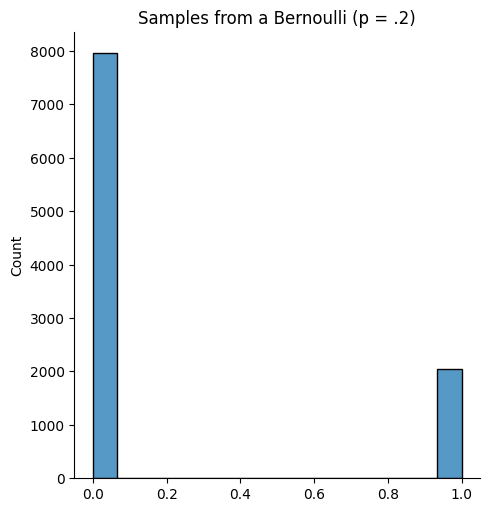

In [84]:
bernoulli = distribution.Bernoulli(0.2)

sample = bernoulli.sample((10000, ))

sns.displot(sample)
plt.title("Samples from a Bernoulli (p = .2)")
torch.mean(sample)
print(sample[:10])

In [90]:
from torch.autograd import Variable
x = torch.Tensor(sample)
p = Variable(torch.rand(1), requires_grad=True)

Now we can use our estimator to gradually compute the Maximum Likelihood, in order to uncover the estimated probability of the underlying distribution, solely based on observing the samples.

In [ ]:
learning_rate = 2e-5
for t in range(50):

    # Negative log-likelihood
    NLL = -torch.sum(torch.log(x*p + (1-x)*(1-p) + 1e-10) )

    # Automatic differentiation
    NLL.backward()
    p.data
    p.grad.data

    if t % 10 == 0:
        print("loglik = %.4f - p = %.4f - dL/dp = %.4f"%(NLL.data.numpy(), p.data.numpy(), p.grad.data.numpy()))   
    p.data -= learning_rate * p.grad.data
    p.grad.data.zero_()
    
print('Final probability p =', p.data[0])

loglik = 5617.2705 - p = 0.3570 - dL/dp = 6662.0039
loglik = 5060.3408 - p = 0.2041 - dL/dp = 0.0000
loglik = 5060.3408 - p = 0.2041 - dL/dp = 0.0000
loglik = 5060.3408 - p = 0.2041 - dL/dp = 0.0000
loglik = 5060.3408 - p = 0.2041 - dL/dp = 0.0000
Final probability p = tensor(0.2041)


/var/folders/yn/w0cxtyxj4g7d_6m2qs3m4trw0000gn/T/ipykernel_55492/3731460994.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("loglik = %.4f - p = %.4f - dL/dp = %.4f"%(NLL.data.numpy(), p.data.numpy(), p.grad.data.numpy()))


# Exercise 1

Try to sample manually from the beta distribution

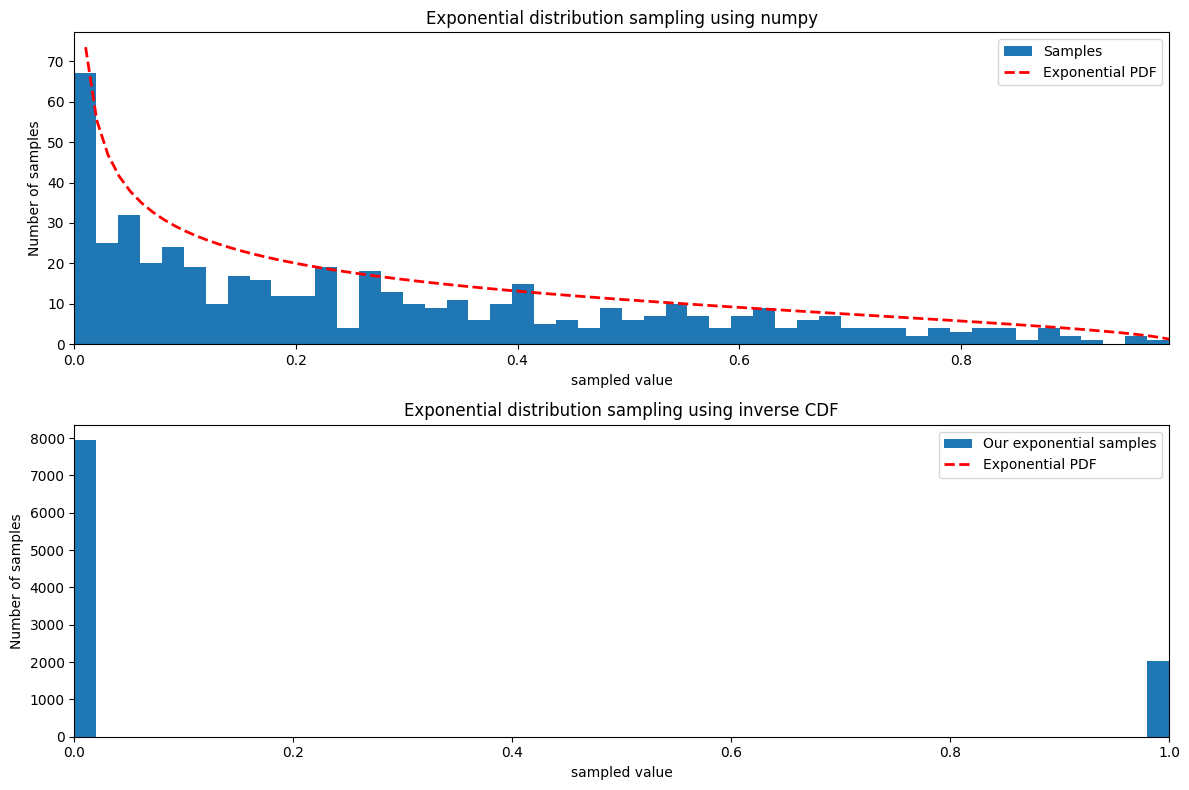

In [ ]:
from scipy.stats import beta

nb_samples = 500
nb_bins = 50

def sample_beta(a, b, N):

    ######################
    # YOUR CODE GOES HERE
    ######################

    return samples


a = 0.6
b = 1.5

samples = np.random.beta(a, b, nb_samples)
samples_manual = sample_beta(a, b, nb_samples)

# Compute the PDF
X = np.linspace(0, 1, 100)
y_1 = beta.pdf(X, a, b) * (nb_samples / nb_bins) * (np.max(samples) * 1.5)

## calculate the pdf of beta manually (X_manual and y_manual) ##

# Display both
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
counts, bin_edges, _ = plt.hist(samples, 50, label='Samples')
bin_width = bin_edges[1] - bin_edges[0]
plt.plot(X, y_1, ls='--',c='r',linewidth=2, label='Exponential PDF')
plt.legend(loc=1)
plt.xlim(0, max(samples))
plt.xlabel('sampled value')
plt.ylabel('Number of samples')
plt.title('Exponential distribution sampling using numpy')

plt.subplot(2,1,2)
counts, bin_edges, _ = plt.hist(samples_manual, 50, label='Our exponential samples')
bin_width = bin_edges[1] - bin_edges[0]
plt.plot(X_manual, y_manual,ls='--',c='r',linewidth=2, label='Exponential PDF')
plt.legend(loc=1)
plt.xlabel('sampled value')
plt.ylabel('Number of samples')
plt.xlim(0, max(samples_manual))
plt.title('Exponential distribution sampling using inverse CDF')
plt.tight_layout()
plt.show()